In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

import seaborn as sns

from keras import Sequential
from keras import layers
from keras import callbacks

plt.style.use('ggplot')
sns.set_palette(sns.color_palette('hls', 10))

**In this notebook we will make forecast using weekly data, not monthly data.**
As we have more data, we will use a train-test approach (in R we didn't split the data).

# Load data

In [2]:
# Load data
data = pd.read_csv('hungary_chickenpox.csv')
display(data.head())

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [3]:
# Set correct data type and set new index
data.Date = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)
display(data.head())

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
2005-01-24,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
2005-01-31,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


# Univariate

In [4]:
# Constants
LOOKBACK: int = 26
TRAIN_SIZE: float = 0.6
VALIDATION_SIZE: float = 0.2
FORECAST_HORIZON: int = 1

In [5]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=10
)

In [6]:
# Create univariate timeseries by using the country total
total_ts = data.sum(axis=1)
total_ts.name = 'weekly_cases'
display(total_ts.head())

Date
2005-01-03    1807
2005-01-10    1407
2005-01-17    1284
2005-01-24    1255
2005-01-31    1478
Name: weekly_cases, dtype: int64

## Set up data

In [7]:
# Create data for RNN
def create_X_y(tseries: np.ndarray, lookback: int = LOOKBACK, forecast_horizon: int = FORECAST_HORIZON) -> (np.ndarray, np.ndarray):
    result_x = []
    result_y = []
    for i in range(len(tseries) - lookback - forecast_horizon + 1):
        result_x.append(np.reshape(tseries[i: i + lookback], (lookback, -1)))
        result_y.append(tseries[i + lookback + forecast_horizon - 1])
    return np.array(result_x), np.array(result_y)

In [8]:
X, y = create_X_y(total_ts.values)
print(f'{len(total_ts) = }')
print(f'{X.shape = }\n{y.shape = }')

len(total_ts) = 522
X.shape = (496, 26, 1)
y.shape = (496,)


# Train - test split

In [9]:
X_train = X[:int(len(X) * TRAIN_SIZE)]
y_train = y[:int(len(y) * TRAIN_SIZE)]
X_val = X[int(len(X) * TRAIN_SIZE): int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE))]
y_val = y[int(len(y) * TRAIN_SIZE): int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE))]
X_test = X[int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE)):]
y_test = y[int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE)):]
print(f'{X_train.shape = }\n{y_train.shape = }\n{X_val.shape = }\n{y_val.shape = }\n{X_test.shape = }\n{y_test.shape = }')

X_train.shape = (297, 26, 1)
y_train.shape = (297,)
X_val.shape = (99, 26, 1)
y_val.shape = (99,)
X_test.shape = (100, 26, 1)
y_test.shape = (100,)


In [10]:
# Select dates
train_dates = total_ts.index[LOOKBACK: LOOKBACK + X_train.shape[0]]
val_dates = total_ts.index[LOOKBACK + X_train.shape[0]: LOOKBACK + X_train.shape[0] + X_val.shape[0]]
test_dates = total_ts.index[LOOKBACK + X_train.shape[0] + X_val.shape[0]:]

## Scale data
Assuming that the theoretical minimum is zero, we will scale data only by dividing by the train maximum. It is similar to MinMaxScaler but not exactly the same.

In [11]:
divisor = X_train.max()
print(f'{divisor = }')

divisor = 2646


In [12]:
# Scale train, val and test with same divisor
X_train_scaled = X_train / divisor
X_test_scaled = X_test / divisor
X_val_scaled = X_val / divisor
y_val_scaled = y_val / divisor
y_train_scaled = y_train / divisor
y_test_scaled = y_test / divisor

## RNN

In [13]:
def create_RNN_model(hidden_units: int,
                     lookback: int = LOOKBACK,
                     optimizer: str = 'adam',
                     loss: str = "mean_squared_error",
                     hidden_activation: str = 'relu') -> Sequential:
    model = Sequential()
    model.add(
        layers.InputLayer(
            shape=(lookback, 1),
            return_sequences=True
        )
    )
    model.add(
        layers.SimpleRNN(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = True,
        )
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(
        layers.SimpleRNN(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = False,
        )
    )
    model.add(
        layers.Dense(units=1, activation="relu") # Activation = relu because prediction must be always >= 0
    )
    # Compile model
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [14]:
# Initialize model
RNN = create_RNN_model(hidden_units=LOOKBACK, hidden_activation='sigmoid')
print(RNN.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 26, 26)         │           728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 26)             │         1,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,133 (8.33 KB)

 Trainable params: 2,133 (8.33 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=10
)
# Fit model
history = RNN.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0529 - val_loss: 0.0308
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0611 - val_loss: 0.0356
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0542 - val_loss: 0.0322
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0575 - val_loss: 0.0337
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0509 - val_loss: 0.0315
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0462 - val_loss: 0.0327
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0498 - val_loss: 0.0310
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0474 - val_loss: 0.0311
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0450 - val_loss: 0.0310
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0417 - val_loss: 0.0318
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0426 - val_loss: 0.0297
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

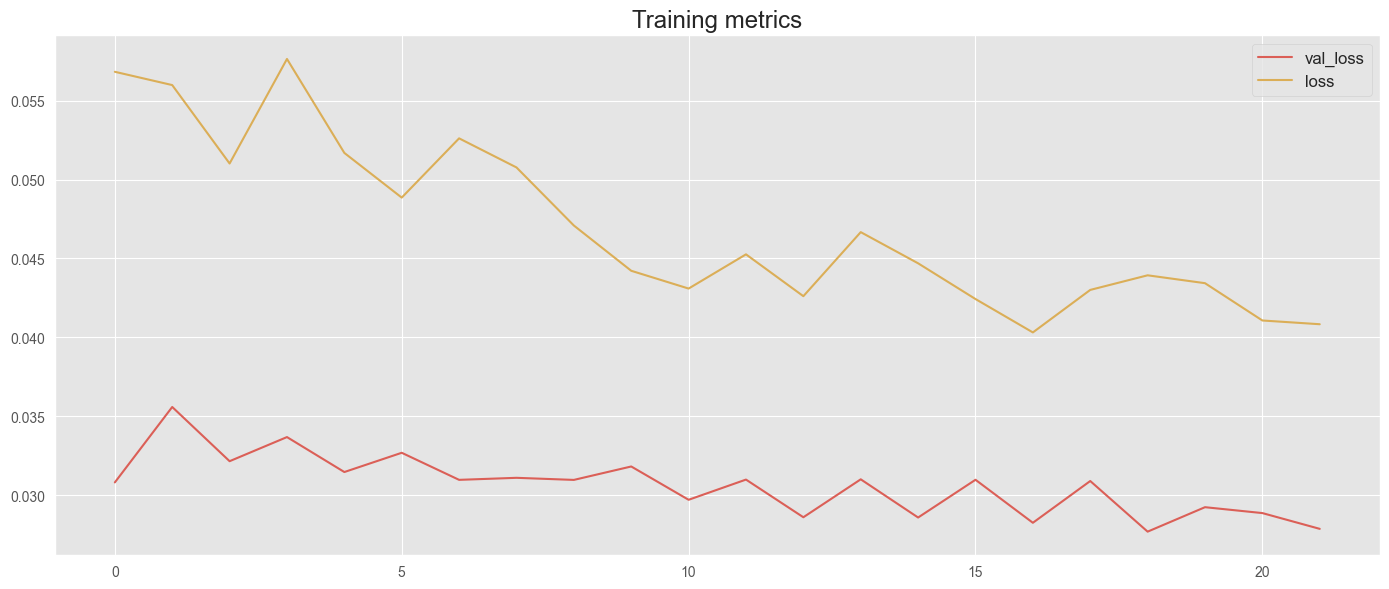

In [16]:
fig1, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(history.history['val_loss'], label='val_loss')
ax.plot(history.history['loss'], label='loss')
ax.legend(fontsize='large')
ax.set_title('Training metrics', fontsize='xx-large')
plt.show()

In [17]:
# Prediction on test
y_pred_RNN = divisor * RNN.predict(X_test_scaled)  # We need to multiply for the divisor used for scaling

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


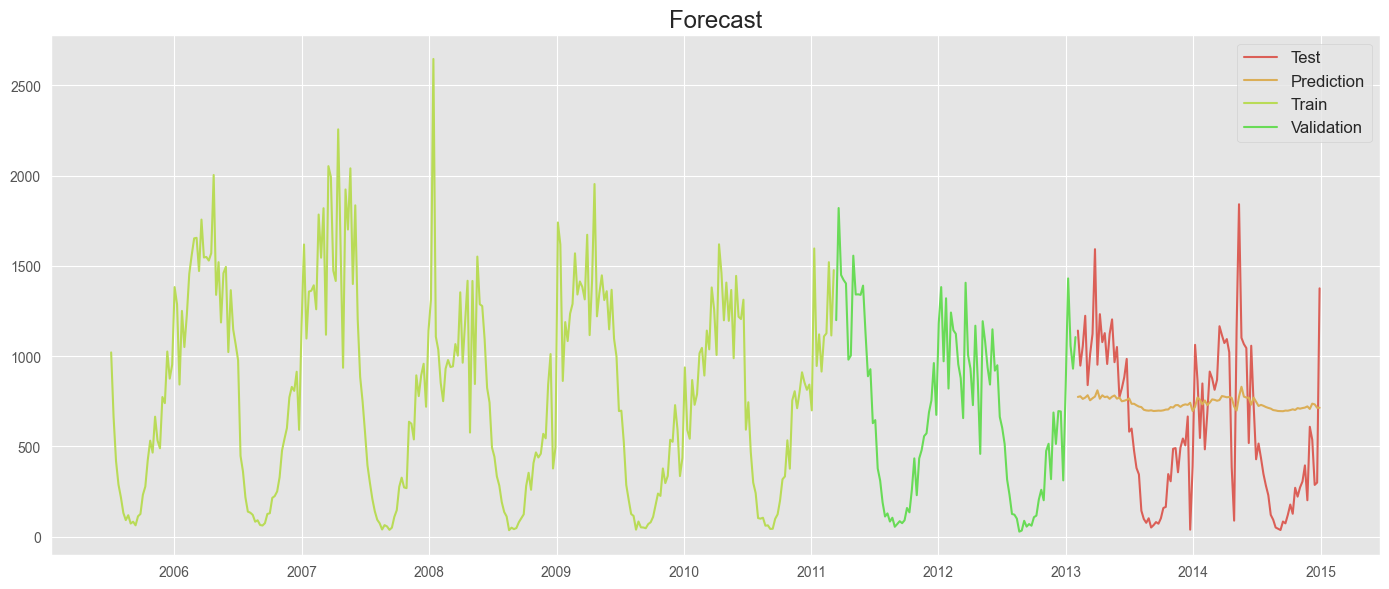

In [18]:
fig2, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(test_dates, y_test, label='Test')
ax.plot(test_dates, y_pred_RNN, label='Prediction')
ax.plot(train_dates, y_train, label='Train')
ax.plot(val_dates, y_val, label='Validation')
ax.legend(fontsize='large')
ax.set_title('Forecast', fontsize='xx-large')
plt.show()

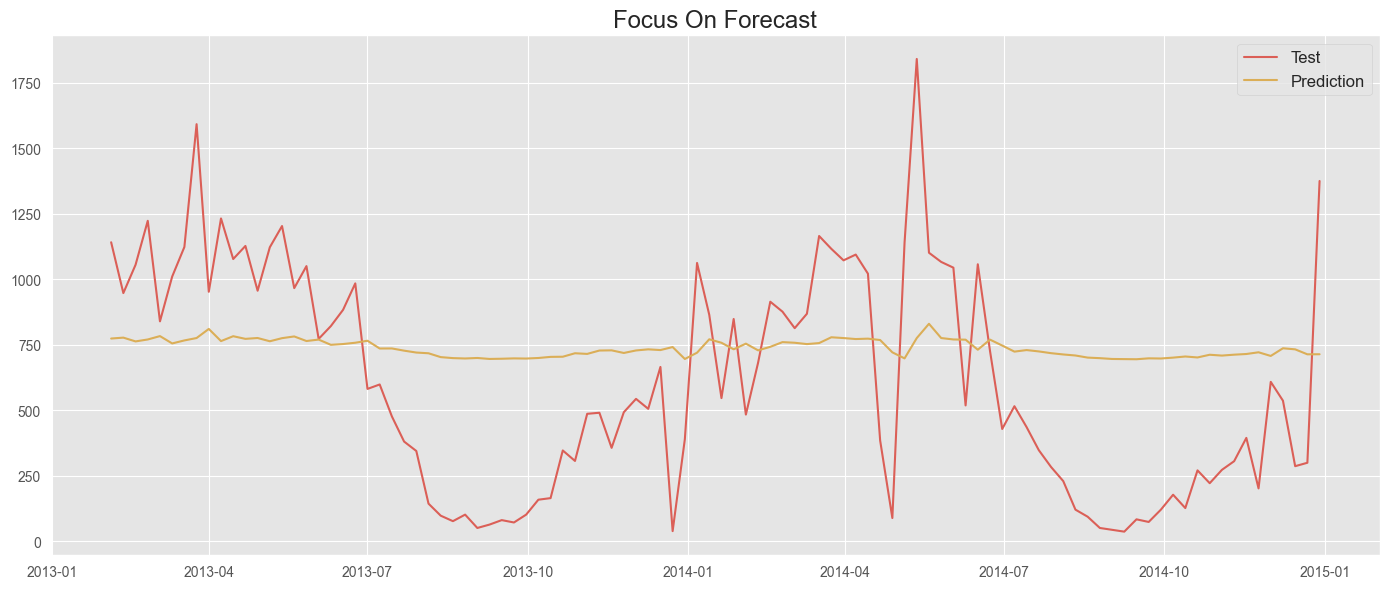

In [19]:
fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(test_dates, y_test, label='Test')
ax.plot(test_dates, y_pred_RNN, label='Prediction')
ax.legend(fontsize='large')
ax.set_title('Focus On Forecast', fontsize='xx-large')
plt.show()

In [20]:
# Performance metrics
print(f'MSE = {mean_squared_error(y_test, y_pred_RNN)}')
print(f'RMSE = {root_mean_squared_error(y_test, y_pred_RNN)}')
print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred_RNN)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred_RNN)}')

MSE = 175825.70996112388
RMSE = 419.31576402649574
MAPE = 2.310560838509798
MAE = 368.72430236816405


# LSTM

In [21]:
def create_LSTM_model(hidden_units: int,
                      lookback: int = LOOKBACK,
                      optimizer: str = 'adam',
                      loss: str = "mean_squared_error",
                      hidden_activation: str = 'relu') -> Sequential:
    model = Sequential()
    model.add(
        layers.InputLayer(
            shape=(lookback, 1),
            return_sequences=True
        )
    )
    model.add(
        layers.LSTM(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = True,
        )
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(
        layers.LSTM(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = False,
        )
    )
    model.add(
        layers.Dense(units=1, activation="relu") # Activation = relu because prediction must be always >= 0
    )
    # Compile model
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [22]:
# Initialize model
LSTM = create_LSTM_model(hidden_units=LOOKBACK, hidden_activation='sigmoid')
print(LSTM.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 26, 26)         │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 26)             │         5,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,451 (33.01 KB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Fit model
history = LSTM.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1318 - val_loss: 0.0967
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1259 - val_loss: 0.0967
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1303 - val_loss: 0.0967
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1285 - val_loss: 0.0967
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1229 - val_loss: 0.0967
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1382 - val_loss: 0.0967
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1292 - val_loss: 0.0967
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1301 - val_loss: 0.0967
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1247 - val_loss: 0.0967
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1256 - val_loss: 0.0967
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1343 - val_loss: 0.0967
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

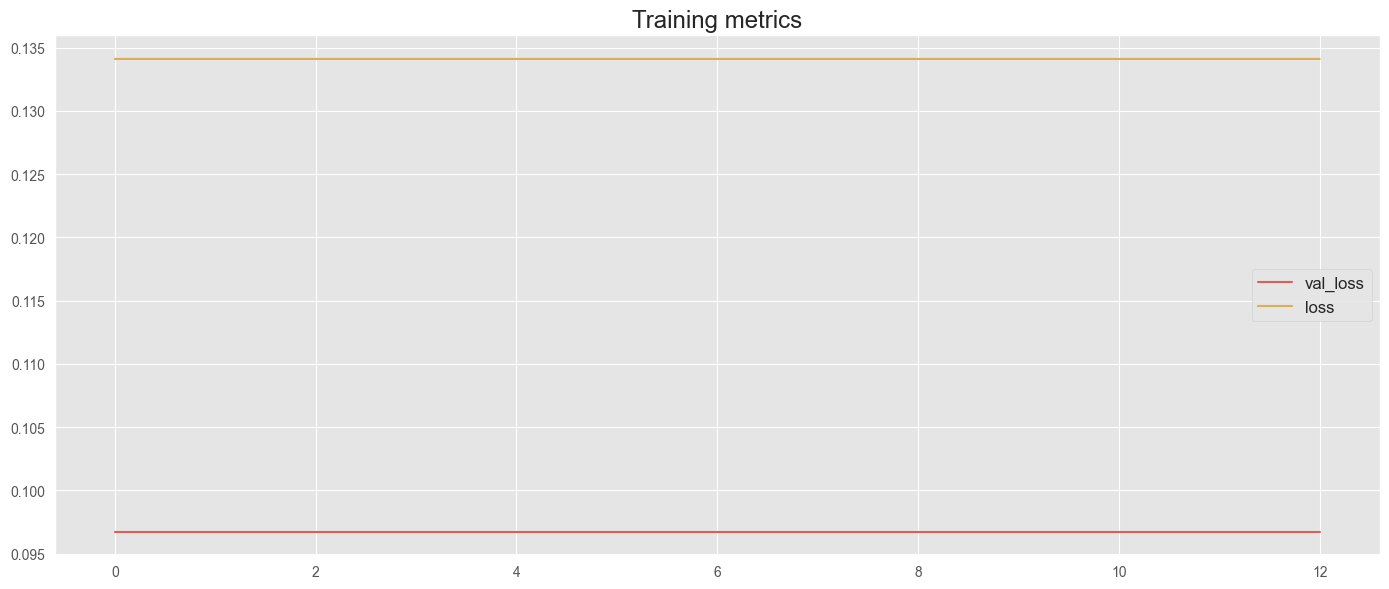

In [24]:
fig4, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(history.history['val_loss'], label='val_loss')
ax.plot(history.history['loss'], label='loss')
ax.legend(fontsize='large')
ax.set_title('Training metrics', fontsize='xx-large')
plt.show()

In [25]:
# Prediction on test
y_pred_LSTM = divisor * LSTM.predict(X_test_scaled)  # We need to multiply for the divisor used for scaling

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


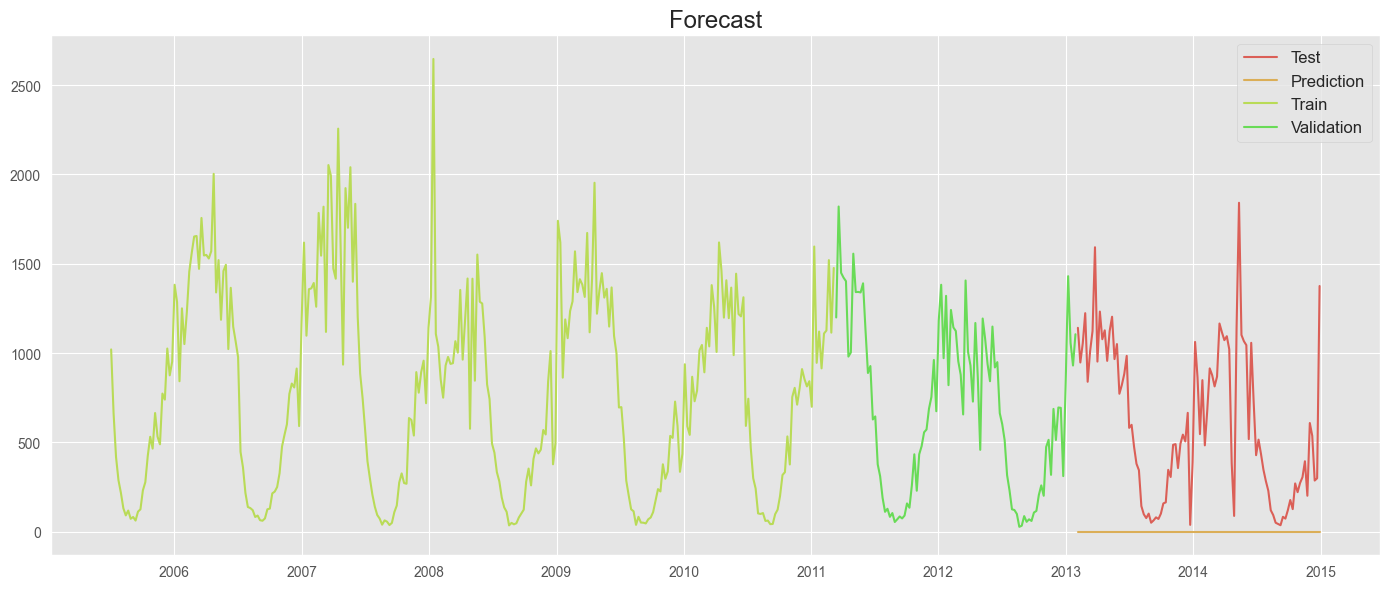

In [26]:
fig5, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(test_dates, y_test, label='Test')
ax.plot(test_dates, y_pred_LSTM, label='Prediction')
ax.plot(train_dates, y_train, label='Train')
ax.plot(val_dates, y_val, label='Validation')
ax.legend(fontsize='large')
ax.set_title('Forecast', fontsize='xx-large')
plt.show()

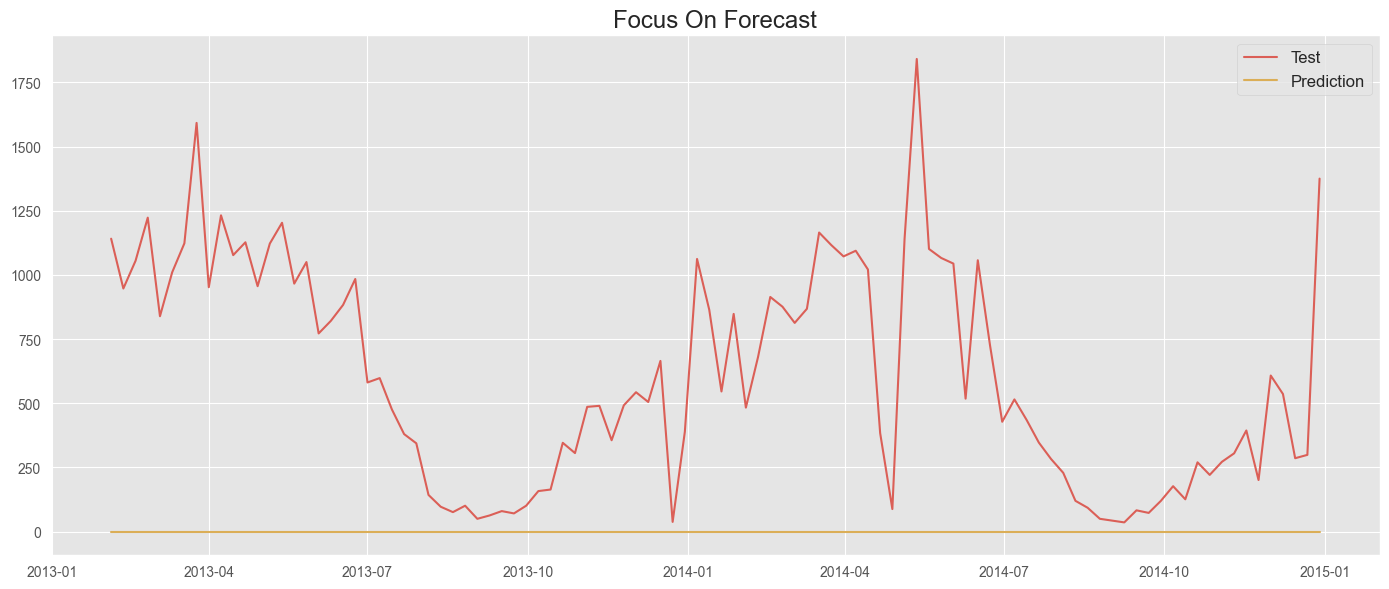

In [27]:
fig6, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(test_dates, y_test, label='Test')
ax.plot(test_dates, y_pred_LSTM, label='Prediction')
ax.legend(fontsize='large')
ax.set_title('Focus On Forecast', fontsize='xx-large')
plt.show()

In [28]:
# Performance metrics
print(f'MSE = {mean_squared_error(y_test, y_pred_LSTM)}')
print(f'RMSE = {root_mean_squared_error(y_test, y_pred_LSTM)}')
print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred_LSTM)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred_LSTM)}')

MSE = 543568.93
RMSE = 737.2712730060762
MAPE = 1.0
MAE = 604.87


# MULTIVARIATE
In this case we don't need to aggregate data

In [29]:
# Constants
LOOKBACK: int = 26
TRAIN_SIZE: float = 0.6
VALIDATION_SIZE: float = 0.2
FORECAST_HORIZON: int = 1

In [30]:
# Scale data before creating X an y
divisor = data[:int(TRAIN_SIZE * (len(data) - LOOKBACK - FORECAST_HORIZON + 1))].max().values
print(divisor)
data_scaled = data / divisor
display(data_scaled.head())

[479 145 238 271 355 199 164 181 262 210 224 160 112 431 155 203 118 141
 230 107]


,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.350731,0.544828,0.126050,0.638376,0.476056,0.211055,0.829268,0.662983,0.618321,0.171429,0.580357,0.35625,0.017857,0.412993,0.425806,0.315271,0.093220,0.205674,0.378261,0.635514
2005-01-10,0.327766,0.413793,0.126050,0.339483,0.563380,0.266332,0.310976,0.386740,0.320611,0.133333,0.357143,0.31250,0.258929,0.327146,0.309677,0.142857,0.491525,0.375887,0.295652,0.242991
2005-01-17,0.200418,0.303448,0.130252,0.317343,0.261972,0.150754,0.567073,0.464088,0.729008,0.242857,0.285714,0.28750,0.035714,0.364269,0.212903,0.162562,0.203390,0.127660,0.269565,0.411215
2005-01-24,0.340292,0.337931,0.180672,0.464945,0.129577,0.195980,0.317073,0.629834,0.408397,0.200000,0.281250,0.33750,0.125000,0.248260,0.425806,0.246305,0.211864,0.148936,0.186957,0.289720
2005-01-31,0.254697,0.537931,0.222689,0.321033,0.290141,0.170854,0.579268,0.723757,0.656489,0.190476,0.272321,0.30625,0.098214,0.287703,0.406452,0.275862,0.059322,0.333333,0.369565,0.560748


In [31]:
X, y = create_X_y(data_scaled.values)

In [32]:
X_train_scaled = X[:int(len(X) * TRAIN_SIZE)]
y_train_scaled = y[:int(len(y) * TRAIN_SIZE)]
X_val_scaled = X[int(len(X) * TRAIN_SIZE): int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE))]
y_val_scaled = y[int(len(y) * TRAIN_SIZE): int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE))]
X_test_scaled = X[int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE)):]
y_test_scaled = y[int(len(X) * (TRAIN_SIZE + VALIDATION_SIZE)):]
print(f'{X_train.shape = }\n{y_train.shape = }\n{X_val.shape = }\n{y_val.shape = }\n{X_test.shape = }\n{y_test.shape = }')

X_train.shape = (297, 26, 1)
y_train.shape = (297,)
X_val.shape = (99, 26, 1)
y_val.shape = (99,)
X_test.shape = (100, 26, 1)
y_test.shape = (100,)


## RNN

In [33]:
def create_RNN_model(hidden_units: int,
                     lookback: int = LOOKBACK,
                     optimizer: str = 'adam',
                     loss: str = "mean_squared_error",
                     hidden_activation: str = 'relu') -> Sequential:
    model = Sequential()
    model.add(
        layers.InputLayer(
            shape=(lookback, 20),  # Change here
            return_sequences=True
        )
    )
    model.add(
        layers.SimpleRNN(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = True,
        )
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(
        layers.SimpleRNN(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = False,
        )
    )
    model.add(
        layers.Dense(units=20, activation="relu") # Activation = relu because prediction must be always >= 0
    )
    # Compile model
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [34]:
# Initialize model
RNN = create_RNN_model(hidden_units=LOOKBACK, hidden_activation='sigmoid')
print(RNN.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 26, 26)         │         1,222 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 26)             │         1,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,140 (12.27 KB)

 Trainable params: 3,140 (12.27 KB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
# Fit model
history = RNN.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2004 - val_loss: 0.1023
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1020 - val_loss: 0.0505
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0599 - val_loss: 0.0342
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0469 - val_loss: 0.0306
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0438 - val_loss: 0.0286
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0450 - val_loss: 0.0278
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384 - val_loss: 0.0289
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0380 - val_loss: 0.0281
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0379 - val_loss: 0.0282
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0388 - val_loss: 0.0280
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0396 - val_loss: 0.0281
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 

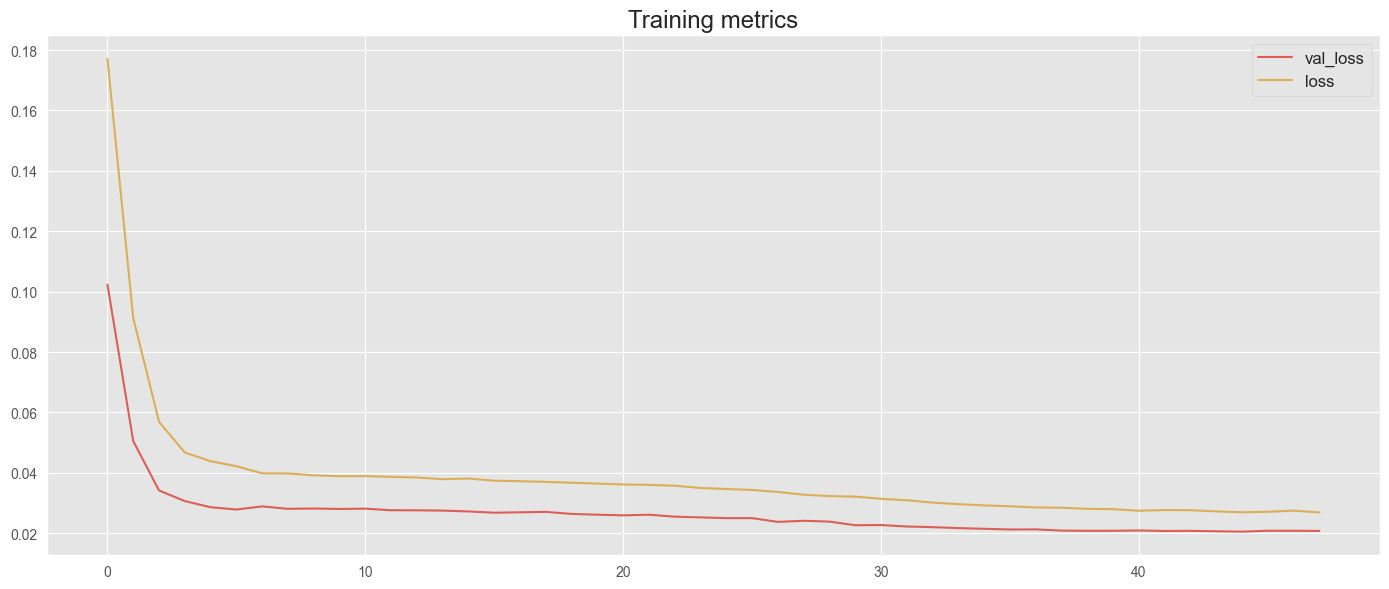

In [36]:
fig7, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(history.history['val_loss'], label='val_loss')
ax.plot(history.history['loss'], label='loss')
ax.legend(fontsize='large')
ax.set_title('Training metrics', fontsize='xx-large')
plt.show()

In [37]:
# Prediction on test
y_pred_RNN = divisor * RNN.predict(X_test_scaled)  # We need to multiply for the divisor used for scaling

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000013B8CEB1AB0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [38]:
# Performance metrics
print(f'MSE = {mean_squared_error(y_test_scaled * divisor, y_pred_RNN)}')

MSE = 826.9410003527819


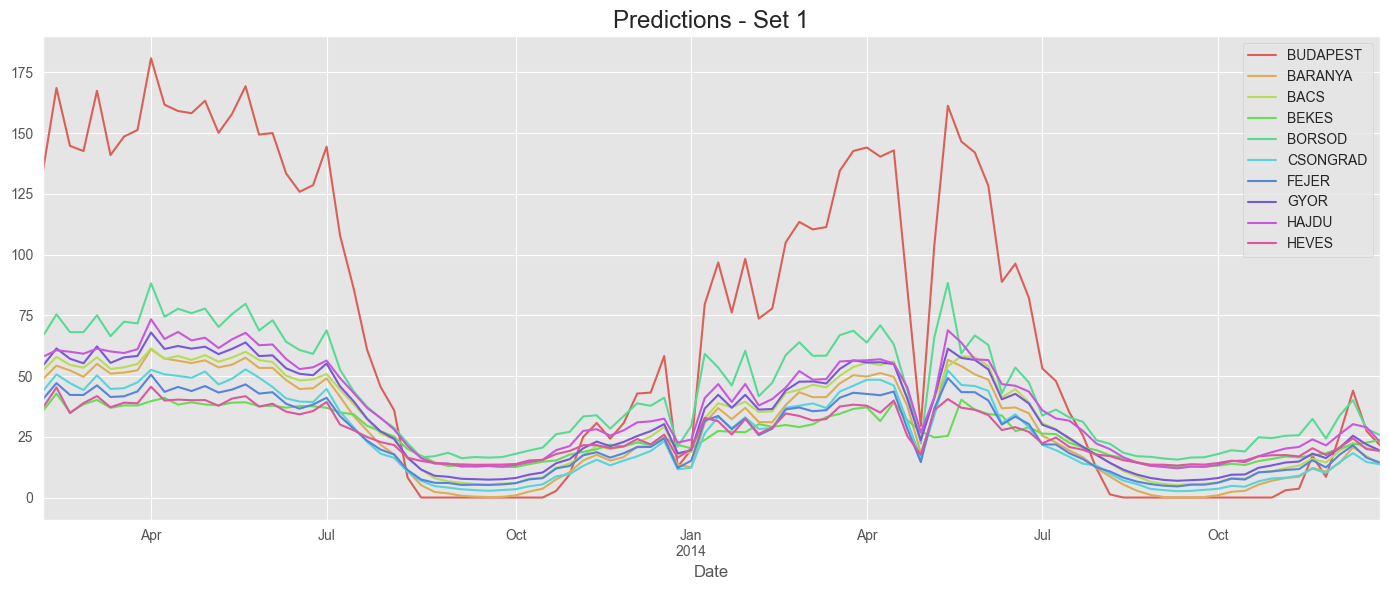

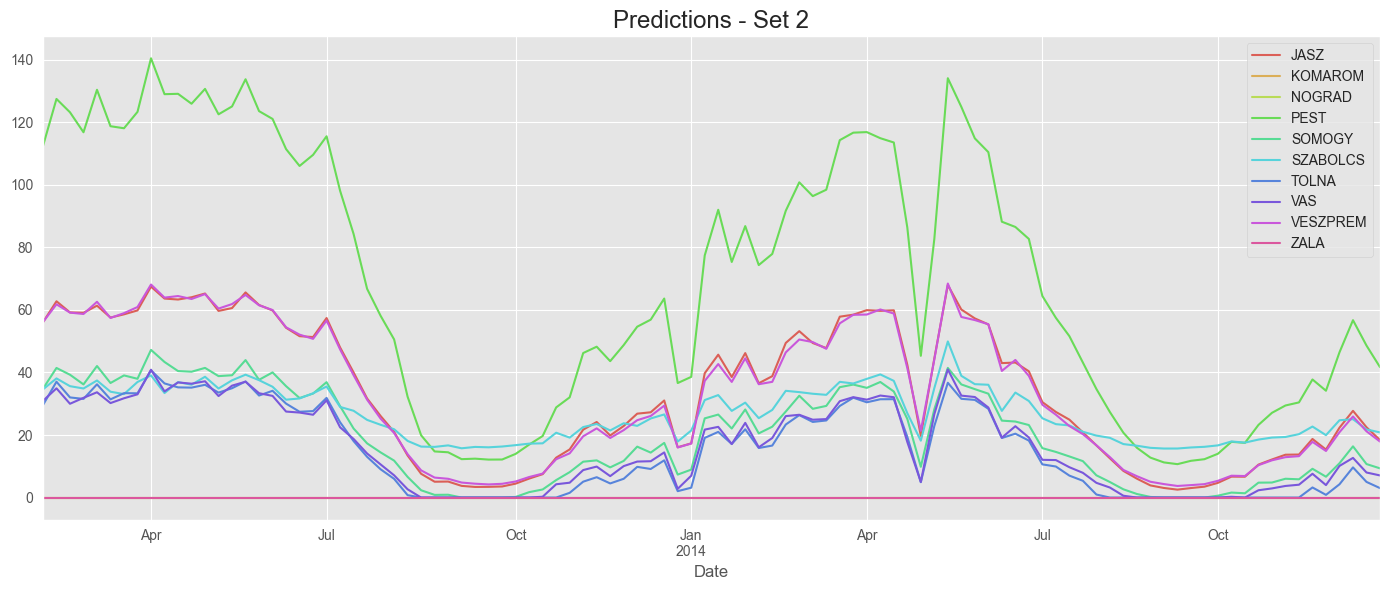

In [39]:
y_pred_RNN = pd.DataFrame(y_pred_RNN, columns=data.columns, index=test_dates)

fig8, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
y_pred_RNN.iloc[:, :10].plot(ax=ax)
ax.set_title('Predictions - Set 1', fontsize='xx-large')

fig9, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
y_pred_RNN.iloc[:, 10:].plot(ax=ax)
ax.set_title('Predictions - Set 2', fontsize='xx-large')

plt.show()

# LSTM

In [40]:
def create_LSTM_model(hidden_units: int,
                      lookback: int = LOOKBACK,
                      optimizer: str = 'adam',
                      loss: str = "mean_squared_error",
                      hidden_activation: str = 'relu') -> Sequential:
    model = Sequential()
    model.add(
        layers.InputLayer(
            shape=(lookback, 20),  # Change here
            return_sequences=True
        )
    )
    model.add(
        layers.LSTM(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = True,
        )
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(
        layers.LSTM(
            units=hidden_units,
            activation = hidden_activation,
            return_sequences = False,
        )
    )
    model.add(
        layers.Dense(units=20, activation="relu") # Activation = relu because prediction must be always >= 0
    )
    # Compile model
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [41]:
# Initialize model
LSTM = create_LSTM_model(hidden_units=LOOKBACK, hidden_activation='sigmoid')
print(LSTM.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 26, 26)         │         4,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 26)             │         5,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,940 (42.73 KB)

 Trainable params: 10,940 (42.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
# Fit model
history = LSTM.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0712 - val_loss: 0.0404
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0512 - val_loss: 0.0366
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0485 - val_loss: 0.0371
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0504 - val_loss: 0.0377
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0472 - val_loss: 0.0370
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0510 - val_loss: 0.0363
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0474 - val_loss: 0.0365
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0508 - val_loss: 0.0368
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0467 - val_loss: 0.0364
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0452 - val_loss: 0.0362
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0472 - val_loss: 0.0364
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

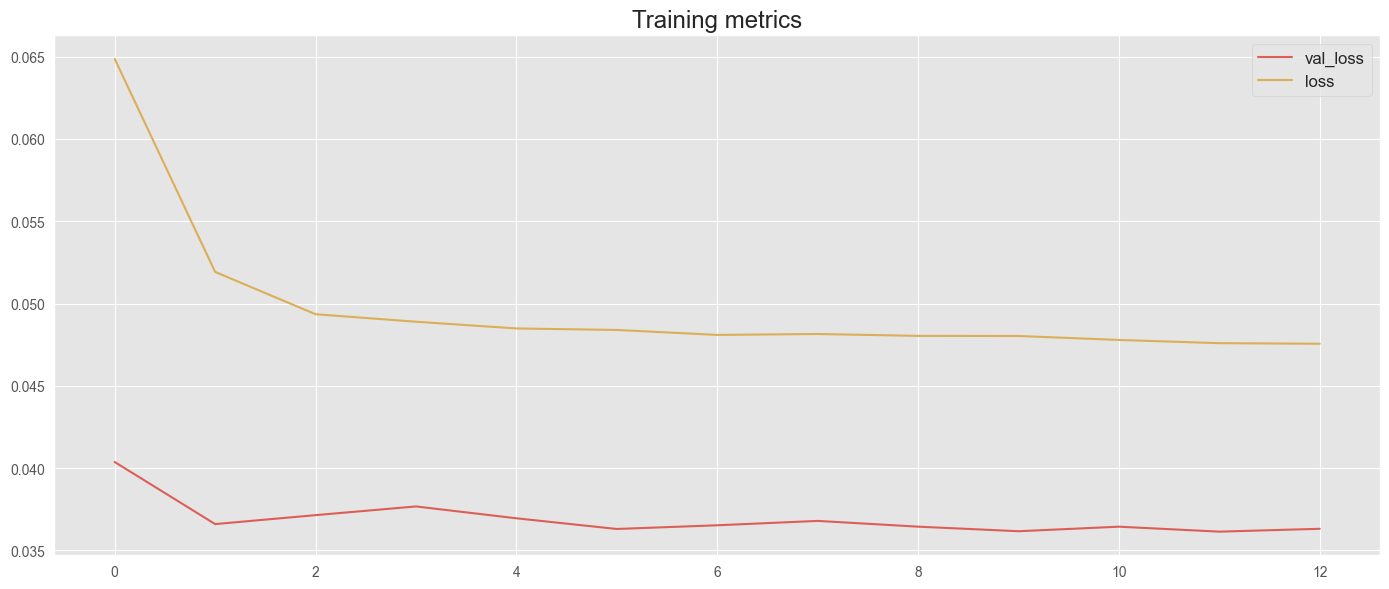

In [43]:
fig8, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(history.history['val_loss'], label='val_loss')
ax.plot(history.history['loss'], label='loss')
ax.legend(fontsize='large')
ax.set_title('Training metrics', fontsize='xx-large')
plt.show()

In [44]:
# Prediction on test
y_pred_LSTM = divisor * LSTM.predict(X_test_scaled)  # We need to multiply for the divisor used for scaling
# Performance metrics
print(f'MSE = {mean_squared_error(y_test_scaled * divisor, y_pred_LSTM)}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
MSE = 1630.068016035903


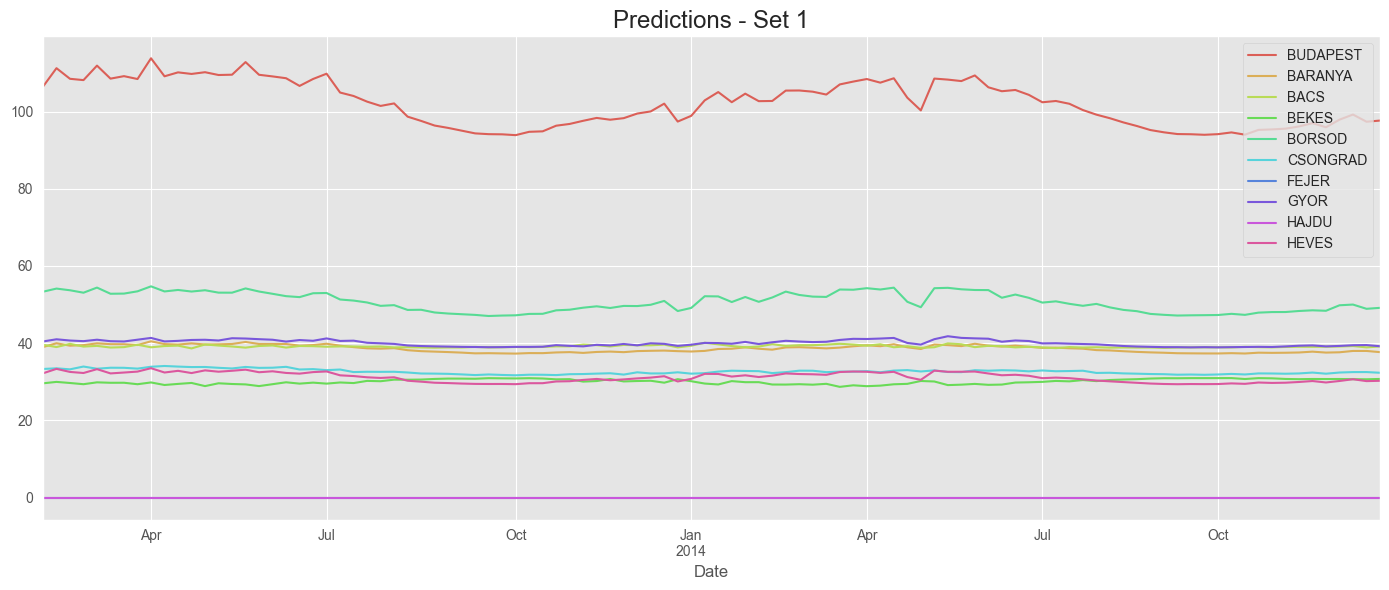

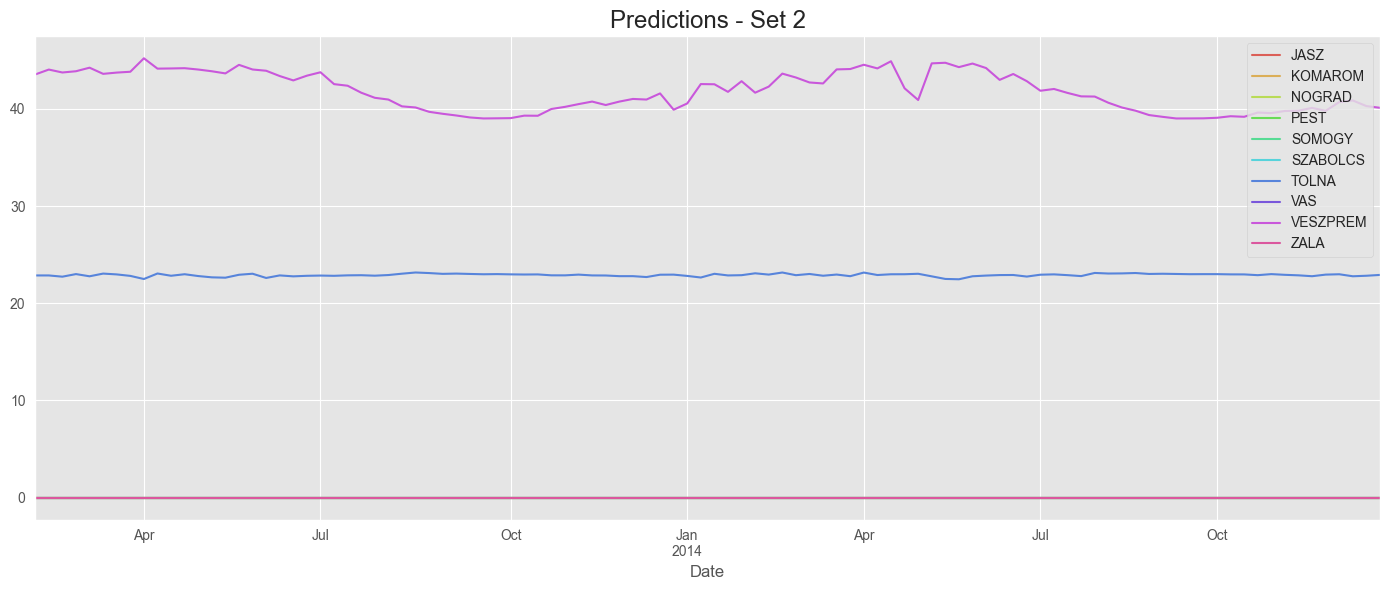

In [45]:
y_pred_LSTM = pd.DataFrame(y_pred_LSTM, columns=data.columns, index=test_dates)

fig10, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
y_pred_LSTM.iloc[:, :10].plot(ax=ax)
ax.set_title('Predictions - Set 1', fontsize='xx-large')

fig11, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
y_pred_LSTM.iloc[:, 10:].plot(ax=ax)
ax.set_title('Predictions - Set 2', fontsize='xx-large')

plt.show()